In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
from FixedPoint import FXnum
import datetime as dt
from enum import Enum

In [2]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = .25/3600
Ki = .25/3600**2
t = 15
delta_t = [3600] * t
price = [1] + [1.01]*(t-1)

config_file = {}
config_file['timedelta'] = delta_t
config_file['market_price'] = price
config_file['kp'] = Kp
config_file['ki'] = Ki

import json
with open('test/config_file.json', 'w') as fp:
    json.dump(config_file, fp)

In [3]:
#python script triggers execution of a solidity test script

In [4]:
#solidity test script simulates contract execution according to the configuration and time series set in file (1)

In [5]:
#solidity test script stores result of the simulation in a predetermined location

In [6]:
from models.market_model.model.state_variables import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = FXnum(config_file[k][0])
            except:
                base_genesis_states[k] = FXnum(config_file[k])
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [7]:
from models.market_model.model.parts.sys_params import params

def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            base_params_dict[k] = [FXnum(config_file[k])]
    return base_params_dict


test_specific_params = pre_process_params_dict(params)

In [8]:
T = 0
for k in config_file.keys():
    if type(config_file[k]) == list:
        T = len(config_file[k])-1
        break

In [9]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['timedelta'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_price'][index]
    return key, value


from models.market_model.model.parts.controllers import *
from models.market_model.model.parts.markets import *
from models.market_model.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [10]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(T),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)


exp.append_configs(initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (14, 19, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.06s


In [11]:
full = pd.DataFrame(raw_result)

In [12]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

fx_cols = ['error_star', 'error_hat', 'old_error_star', 'old_error_hat',
       'error_star_integral', 'error_hat_integral', 'error_star_derivative',
       'error_hat_derivative', 'target_rate', 'target_price', 'market_price',
       'debt_price', 'timedelta']
for c in fx_cols:
    df[c] = df[c].apply(float)

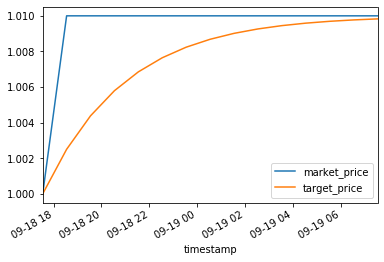

In [13]:
df.plot(x='timestamp', y=['market_price','target_price'])

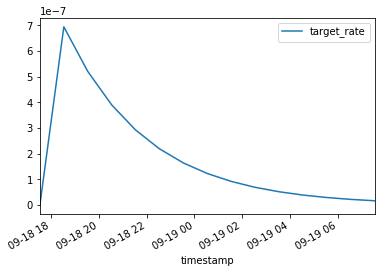

In [14]:
df.plot(x='timestamp', y=['target_rate'])

In [15]:
#python script stores result of the simulation in a predetermined location

In [16]:
#jupyter notebook shows visualizations of the results from solidity 
#implementation and cadCAD model and error metrics